In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Load the train dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

def extract_constituency_type(constituency):
    if '(SC)' in constituency:
        return 1  # For SC
    elif '(ST)' in constituency:
        return 2  # For ST
    else:
        return 0  # For other constituencies

train_data['constituency_type'] = train_data['Constituency'].apply(lambda x: extract_constituency_type(x))
train_data['is_doctor'] = train_data['Candidate'].str.contains('Dr.', case=False).astype(int)

test_data['constituency_type'] = test_data['Constituency'].apply(lambda x: extract_constituency_type(x))
test_data['is_doctor'] = test_data['Candidate'].str.contains('Dr.', case=False).astype(int)



def convert_to_string(amount_str):
    new_string = ''.join(filter(str.isdigit, amount_str))
    if 'Crore' in amount_str:
        integer_value = int(new_string) * 10000000
    elif 'Lac' in amount_str:
        integer_value = int(new_string) * 100000
    elif 'Thou' in amount_str:
        integer_value = int(new_string) * 1000
    elif 'Hund' in amount_str:
        integer_value = int(new_string) * 100
    else:
        integer_value = int(amount_str)
    return integer_value

# Apply the preprocessing function to the 'Amount' column
train_data['Total Assets'] = train_data['Total Assets'].apply(convert_to_string)
train_data['Liabilities'] = train_data['Liabilities'].apply(convert_to_string)
test_data['Total Assets'] = test_data['Total Assets'].apply(convert_to_string)
test_data['Liabilities'] = test_data['Liabilities'].apply(convert_to_string)


train_dummies1 = pd.get_dummies(train_data.state,dtype='int')
train_dummies2 = pd.get_dummies(train_data.Party,dtype='int')
train_data=pd.concat([train_data,train_dummies1,train_dummies2],axis='columns')
# train_data.drop(columns=['state','Party'],inplace=True)

test_dummies1 = pd.get_dummies(test_data.state,dtype='int')
test_dummies2 = pd.get_dummies(test_data.Party,dtype='int')
test_data = pd.concat([test_data,test_dummies1,test_dummies2],axis='columns')
# test_data.drop(columns=['state','Party'],inplace=True)

X_train = train_data.drop(columns=['Education','ID','Candidate','Constituency','state','Party'])
y_train = train_data['Education']
X_test = test_data.drop(columns=['ID','Candidate','Constituency','state','Party'])


train_data

,ID,Candidate,Constituency,Party,Criminal Case,Total Assets,Liabilities,state,Education,constituency_type,...,NCP,NDPP,NPP,RJD,SHS,SP,Sikkim Krantikari Morcha,TDP,Tipra Motha Party,YSRCP
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,2110000000,20000000,TAMIL NADU,8th Pass,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,10000000,0,MADHYA PRADESH,12th Pass,1,...,0,0,0,0,0,0,0,0,0,0
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,70000000,2200000,KARNATAKA,Post Graduate,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Kundan Kumar,BEGUSARAI,BJP,0,90000000,2400000,BIHAR,Post Graduate,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,20000000,6100000,WEST BENGAL,8th Pass,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2054,V. Sasi,CHIRAYINKEEZHU,CPI,1,6100000,1000000,KERALA,Graduate Professional,0,...,0,0,0,0,0,0,0,0,0,0
2055,2055,Pushkar Lal Dangi,MAVLI,INC,0,20000000,800000,RAJASTHAN,10th Pass,0,...,0,0,0,0,0,0,0,0,0,0
2056,2056,Dr. Manju Shiwach,MODI NAGAR,BJP,0,130000000,8500000,UTTAR PRADESH,Graduate,0,...,0,0,0,0,0,0,0,0,0,0
2057,2057,Mansing Fattesingrao Naik,SHIRALA,NCP,1,250000000,9400000,MAHARASHTRA,12th Pass,0,...,1,0,0,0,0,0,0,0,0,0


In [97]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_train[['Total Assets']] = scaler.fit_transform(X_train[['Total Assets']])
X_test[['Total Assets']] = scaler.transform(X_test[['Total Assets']])
X_train[['Liabilities']] = scaler.fit_transform(X_train[['Liabilities']])
X_test[['Liabilities']] = scaler.transform(X_test[['Liabilities']])
X_train[['Criminal Case']] = scaler.fit_transform(X_train[['Criminal Case']])
X_test[['Criminal Case']] = scaler.transform(X_test[['Criminal Case']])

for i in range(len(X_train)):
  if(X_train.iloc[i,0]>100): X_train.iloc[i,0]=0
  if(X_train.iloc[i,1]>100): X_train.iloc[i,1]=0
  if(X_train.iloc[i,2]>100): X_train.iloc[i,2]=0
for i in range(len(X_test)):
  if(X_test.iloc[i,0]>100): X_test.iloc[i,0]=0
  if(X_test.iloc[i,1]>100): X_test.iloc[i,1]=0
  if(X_test.iloc[i,2]>100): X_test.iloc[i,2]=0

X_train


,Criminal Case,Total Assets,Liabilities,constituency_type,is_doctor,ANDHRA PRADESH,ARUNACHAL PRADESH,ASSAM,BIHAR,CHHATTISGARH,...,NCP,NDPP,NPP,RJD,SHS,SP,Sikkim Krantikari Morcha,TDP,Tipra Motha Party,YSRCP
0,2.0,29.645390,2.056149,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,-0.141844,-0.203355,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.709220,0.045190,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.992908,0.067785,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.000000,0.485793,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,0.5,-0.197163,-0.090380,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2055,0.0,0.000000,-0.112975,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2056,0.0,1.560284,0.756934,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2057,0.5,3.262411,0.858612,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_dct = clf.predict(X_test)
y_pred_dct

array(['12th Pass', 'Graduate Professional', 'Post Graduate', ...,
       'Post Graduate', 'Graduate', 'Graduate Professional'], dtype=object)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,3,5,10],
    'kernel':['rbf','linear','poly'],
},cv=5,return_train_score=False)

clf.fit(X_train,y_train)
clf.cv_results_

{'mean_fit_time': array([  0.68321009,   1.30811296,   1.33196783,   0.29433565,
          5.05951376,   1.89392762,   0.3067028 ,  22.68458118,
          2.28771515,   0.31583242, 125.91722894,   4.56056218]),
 'std_fit_time': array([1.43661247e-01, 2.64797746e-01, 5.32031319e-01, 4.52896762e-03,
        3.33709062e+00, 9.74979011e-01, 6.33049714e-03, 7.23398654e+00,
        1.36184217e+00, 3.58933750e-03, 4.06078662e+01, 3.62345847e+00]),
 'mean_score_time': array([0.17371173, 0.05041885, 0.04081435, 0.06315951, 0.03878579,
        0.04281163, 0.06565351, 0.03339319, 0.03699751, 0.06599183,
        0.03860617, 0.03713579]),
 'std_score_time': array([0.04685759, 0.00758917, 0.00788364, 0.00136888, 0.00913957,
        0.00791204, 0.00251577, 0.00029256, 0.00028672, 0.00593228,
        0.0084078 , 0.00066983]),
 'param_C': masked_array(data=[1, 1, 1, 3, 3, 3, 5, 5, 5, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, Fals

In [ ]:
results = pd.DataFrame(clf.cv_results_)
results[['params','mean_test_score']]


,params,mean_test_score
0,"{'C': 1, 'kernel': 'rbf'}",0.257406
1,"{'C': 1, 'kernel': 'linear'}",0.241863
2,"{'C': 1, 'kernel': 'poly'}",0.256920
3,"{'C': 3, 'kernel': 'rbf'}",0.258380
4,"{'C': 3, 'kernel': 'linear'}",0.239922
5,"{'C': 3, 'kernel': 'poly'}",0.254006
6,"{'C': 5, 'kernel': 'rbf'}",0.259836
7,"{'C': 5, 'kernel': 'linear'}",0.239923
8,"{'C': 5, 'kernel': 'poly'}",0.253522
9,"{'C': 10, 'kernel': 'rbf'}",0.244783


In [ ]:
from sklearn.svm import SVC
svm = SVC(C=3,kernel='rbf')
svm.fit(X_train,y_train)
y_pred_svm = svm.predict(X_test)
y_pred_svm

array(['12th Pass', 'Graduate', 'Graduate', ..., 'Graduate', 'Graduate',
       'Post Graduate'], dtype=object)

In [4]:
alphas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
binarizes = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

# Define the hyperparameters you want to tune and their possible values
param_grid = {
    'alpha': alphas ,  # Smoothing parameter
    'binarize': binarizes  # Threshold for binarizing features
}
model = BernoulliNB()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Perform grid search cross-validation
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)



Best hyperparameters: {'alpha': 0.95, 'binarize': 0.5}


In [6]:
# Make predictions on the training data using hyperparameters approximately near the best hyperparameters
# and which give the best results
model_bnb = BernoulliNB(alpha=0.7,binarize=0.2)
model_bnb.fit(X_train,y_train)
y_pred_bnb_gscv = model_bnb.predict(X_test)

y_pred_bnb_gscv

array(['Graduate', '12th Pass', 'Graduate', ..., 'Graduate',
       'Graduate Professional', 'Post Graduate'], dtype='<U21')

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf

array(['Graduate', '8th Pass', 'Graduate Professional', ...,
       'Post Graduate', '10th Pass', 'Graduate'], dtype=object)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
y_pred_knn

array(['12th Pass', '8th Pass', 'Doctorate', ..., '10th Pass',
       '10th Pass', 'Graduate'], dtype=object)

In [9]:
x = np.arange(0,2059,1)
y = np.arange(0,1374,1)

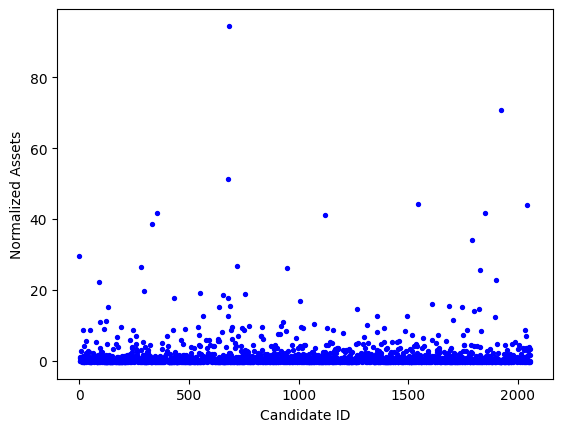

In [10]:
plt.scatter(x,X_train['Total Assets'],color='blue',s=8)
plt.xlabel("Candidate ID")
plt.ylabel("Normalized Assets")
plt.show()

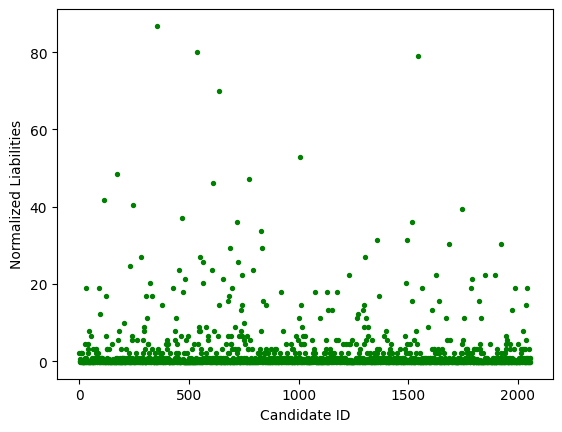

In [11]:
plt.scatter(x,X_train['Liabilities'],color='green',s=8)
plt.xlabel("Candidate ID")
plt.ylabel("Normalized Liabilities")
plt.show()

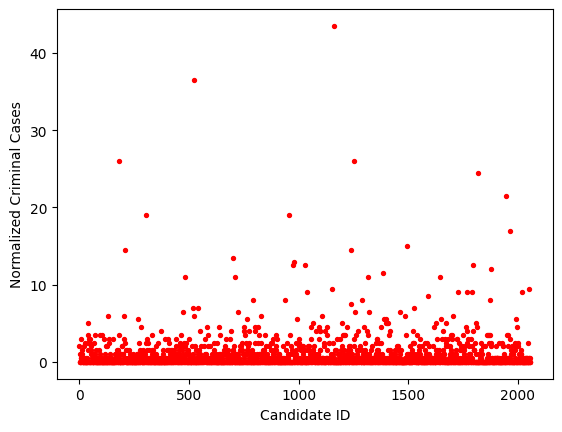

In [12]:
plt.scatter(x,X_train['Criminal Case'],color='red',s=8)
plt.xlabel("Candidate ID")
plt.ylabel("Normalized Criminal Cases")
plt.show()

In [36]:
df = pd.DataFrame(y_pred_bnb_gscv, columns=['Education'])
df.index.names=['ID']
df.to_csv('temp_bnb_gscv.csv')

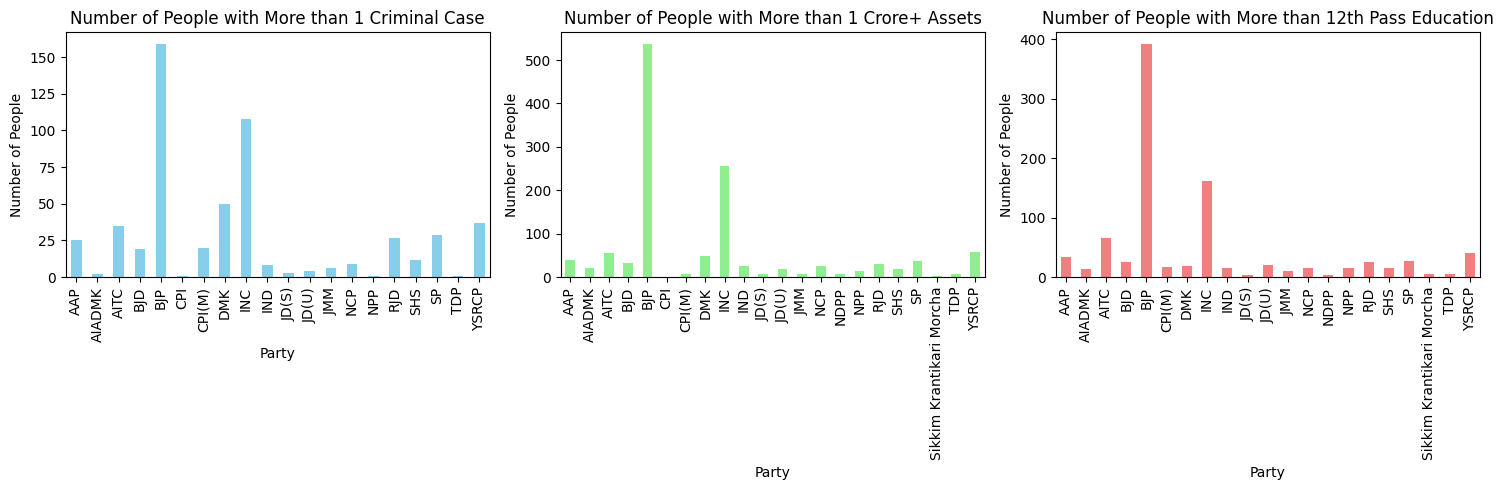

In [99]:
df = train_data.copy()

# Convert 'Education' column to categorical type
df['Education'] = pd.Categorical(df['Education'], ordered=True, categories=['Others', 'Literate', '5th Pass', '8th Pass', '10th Pass', '12th Pass', 'Graduate', 'Graduate Professional' 'Post Graduate', 'Doctorate'])

total_candidates_per_party = df.groupby('Party')['ID'].count()

# Filter data based on conditions
more_than_1_case = df[df['Criminal Case'] > 1]
more_than_1_crore_assets = df[df['Total Assets'] > 1e+07]
more_than_12th_pass_education = df[df['Education'] >= '12th Pass']

# Count the number of people in each party for each condition
party_with_more_than_1_case = more_than_1_case.groupby('Party')['ID'].count()
party_with_more_than_1_crore_assets = more_than_1_crore_assets.groupby('Party')['ID'].count()
party_with_more_than_12th_pass_education = more_than_12th_pass_education.groupby('Party')['ID'].count()

normalized_party_with_more_than_1_case = party_with_more_than_1_case / total_candidates_per_party
normalized_party_with_more_than_1_crore_assets = party_with_more_than_1_crore_assets / total_candidates_per_party
normalized_party_with_more_than_12th_pass_education = party_with_more_than_12th_pass_education / total_candidates_per_party

sc_constituencies = df[df['Constituency'].str.contains('SC')]
st_constituencies = df[df['Constituency'].str.contains('ST')]
other_constituencies = df[~df['Constituency'].str.contains('SC|ST')]

# Count the education levels for each filtered constituency
sc_education_counts = sc_constituencies['Education'].value_counts()
st_education_counts = st_constituencies['Education'].value_counts()
other_education_counts = other_constituencies['Education'].value_counts()

# Plotting the graphs
plt.figure(figsize=(15, 5))

# Plotting number of people with more than 1 criminal case for each party
plt.subplot(1, 3, 1)
party_with_more_than_1_case.plot(kind='bar', color='skyblue')
plt.title('Number of People with More than 1 Criminal Case')
plt.xlabel('Party')
plt.ylabel('Number of People')

# Plotting number of people with more than 1 crore+ assets for each party
plt.subplot(1, 3, 2)
party_with_more_than_1_crore_assets.plot(kind='bar', color='lightgreen')
plt.title('Number of People with More than 1 Crore+ Assets')
plt.xlabel('Party')
plt.ylabel('Number of People')

# Plotting number of people with more than 12th Pass education for each party
plt.subplot(1, 3, 3)
party_with_more_than_12th_pass_education.plot(kind='bar', color='lightcoral')
plt.title('Number of People with More than 12th Pass Education')
plt.xlabel('Party')
plt.ylabel('Number of People')


plt.tight_layout()
plt.show()


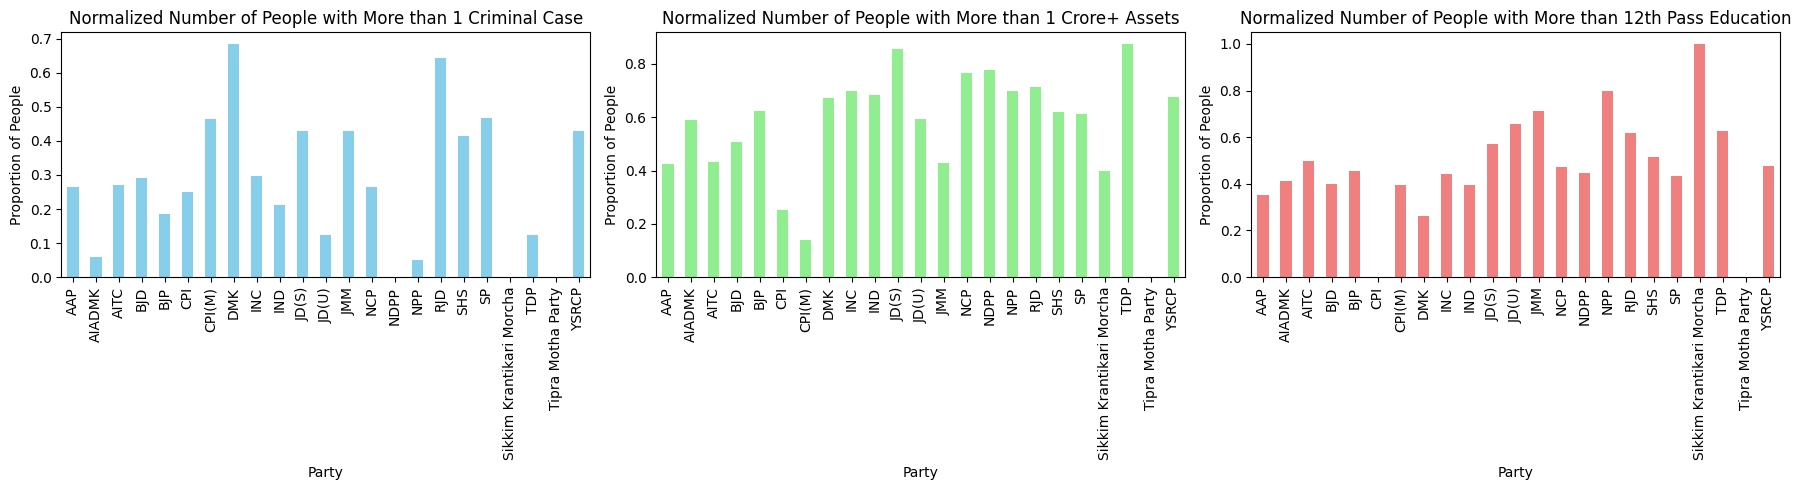

In [100]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
normalized_party_with_more_than_1_case.plot(kind='bar', color='skyblue')
plt.title('Normalized Number of People with More than 1 Criminal Case')
plt.xlabel('Party')
plt.ylabel('Proportion of People')


plt.subplot(1, 3, 2)
normalized_party_with_more_than_1_crore_assets.plot(kind='bar', color='lightgreen')
plt.title('Normalized Number of People with More than 1 Crore+ Assets')
plt.xlabel('Party')
plt.ylabel('Proportion of People')


plt.subplot(1, 3, 3)
normalized_party_with_more_than_12th_pass_education.plot(kind='bar', color='lightcoral')
plt.title('Normalized Number of People with More than 12th Pass Education')
plt.xlabel('Party')
plt.ylabel('Proportion of People')


plt.tight_layout()
plt.show()


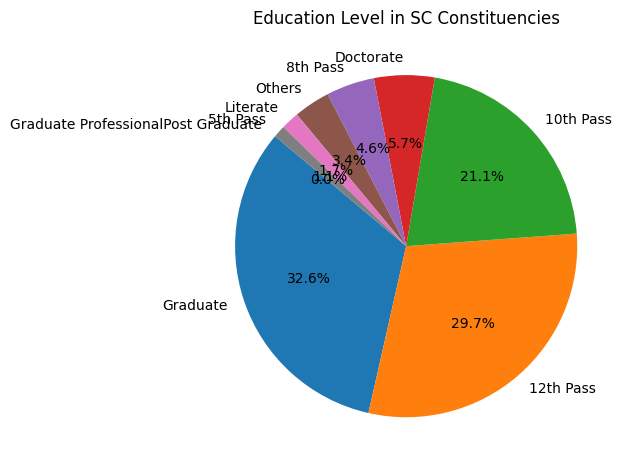

In [91]:
# Pie chart for SC constituencies
# plt.subplot(1, 3, 1)
plt.pie(sc_education_counts, labels=sc_education_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Education Level in SC Constituencies')


plt.tight_layout()
plt.show()





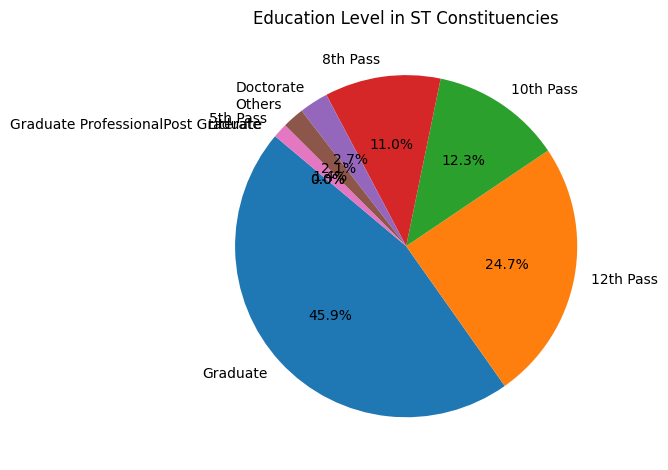

In [101]:
# Pie chart for ST constituencies
# plt.subplot(1, 3, 2)
plt.pie(st_education_counts, labels=st_education_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Education Level in ST Constituencies')

plt.tight_layout()
plt.show()

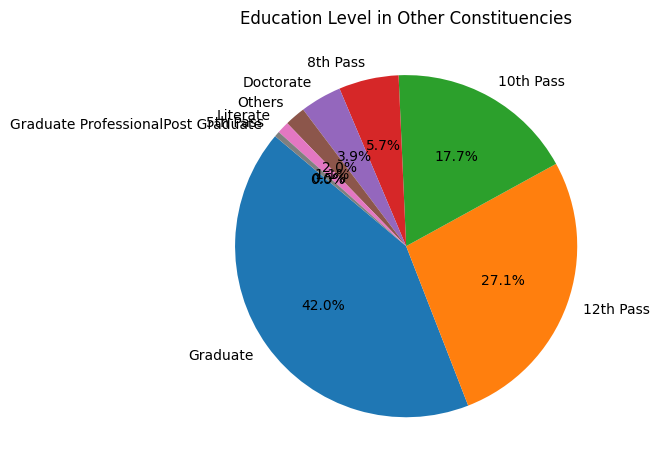

In [102]:
# Pie chart for other constituencies

plt.subplot(1, 3, 3)
plt.pie(other_education_counts, labels=other_education_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Education Level in Other Constituencies')

plt.tight_layout()
plt.show()